In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

2024-01-07 19:01:07.613119: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-07 19:01:07.633689: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-07 19:01:07.633710: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-07 19:01:07.634247: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-07 19:01:07.637754: I tensorflow/core/platform/cpu_feature_guar

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  

def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
  

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

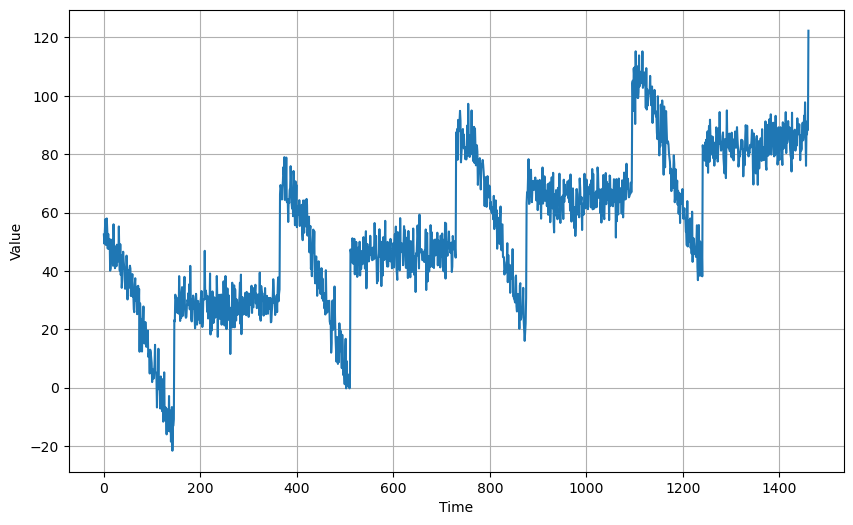

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [5]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer='adam',
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

2024-01-07 19:01:14.440162: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-07 19:01:14.458834: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-07 19:01:14.458950: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/500


2024-01-07 19:01:16.453905: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-07 19:01:16.515209: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-07 19:01:16.971779: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f25e5723dc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-07 19:01:16.971797: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-01-07 19:01:16.974517: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1704672077.013995  215669 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


      8/Unknown - 2s 13ms/step - loss: 20.0641 - mae: 20.5592

2024-01-07 19:01:17.335030: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9696792664454909431
2024-01-07 19:01:17.335052: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10421551712465370262


8/8 [==============================] - 2s 79ms/step - loss: 20.0641 - mae: 20.5592 - val_loss: 14.0806 - val_mae: 14.5712
Epoch 2/500
8/8 [==============================] - 0s 11ms/step - loss: 10.8690 - mae: 11.3587 - val_loss: 11.5337 - val_mae: 12.0219
Epoch 3/500
1/8 [==>...........................] - ETA: 0s - loss: 9.6855 - mae: 10.1740

2024-01-07 19:01:17.770052: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9696792664454909431
2024-01-07 19:01:17.770100: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10421551712465370262
/home/kb/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 0s 9ms/step - loss: 8.4299 - mae: 8.9158 - val_loss: 11.2612 - val_mae: 11.7481
Epoch 4/500
8/8 [==============================] - 0s 10ms/step - loss: 7.1525 - mae: 7.6366 - val_loss: 10.5790 - val_mae: 11.0674
Epoch 5/500
8/8 [==============================] - 0s 10ms/step - loss: 6.2423 - mae: 6.7243 - val_loss: 9.3470 - val_mae: 9.8336
Epoch 6/500
8/8 [==============================] - 0s 8ms/step - loss: 5.5920 - mae: 6.0723 - val_loss: 9.5890 - val_mae: 10.0778
Epoch 7/500
8/8 [==============================] - 0s 16ms/step - loss: 5.1304 - mae: 5.6092 - val_loss: 8.4031 - val_mae: 8.8894
Epoch 8/500
8/8 [==============================] - 0s 10ms/step - loss: 4.9114 - mae: 5.3898 - val_loss: 7.6720 - val_mae: 8.1567
Epoch 9/500
8/8 [==============================] - 0s 9ms/step - loss: 4.7345 - mae: 5.2124 - val_loss: 7.2784 - val_mae: 7.7622
Epoch 10/500
8/8 [==============================] - 0s 14ms/step - loss: 4.6058 - mae: 5.0831 - val_

KeyboardInterrupt: 

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer='adam',
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

In [8]:
rnn_forecast = model_forecast(model, series[:,  np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

45/45 [==============================] - 0s 3ms/step


2024-01-07 18:32:38.769525: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17830816848436515219
2024-01-07 18:32:38.769549: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 7711417923199939559


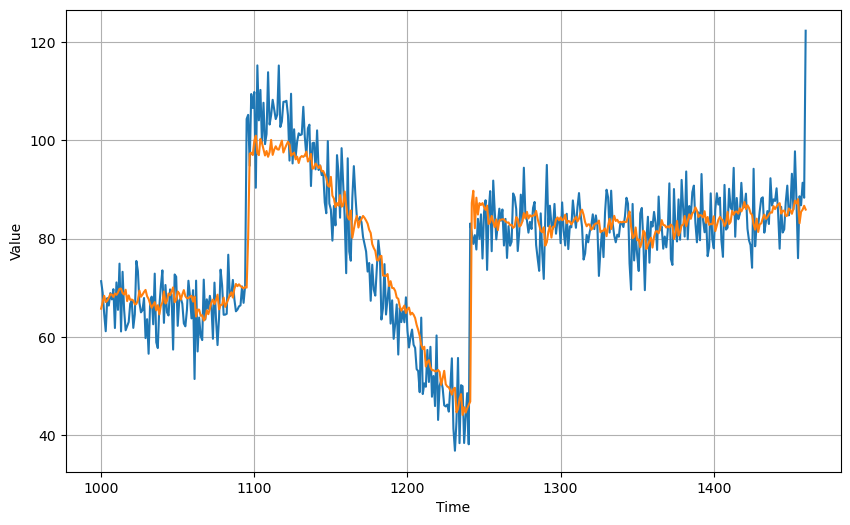

In [9]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [10]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.011326

In [11]:
model = keras.models.load_model("my_checkpoint.h5")
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

45/45 [==============================] - 0s 2ms/step


2024-01-07 18:32:39.415917: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17830816848436515219


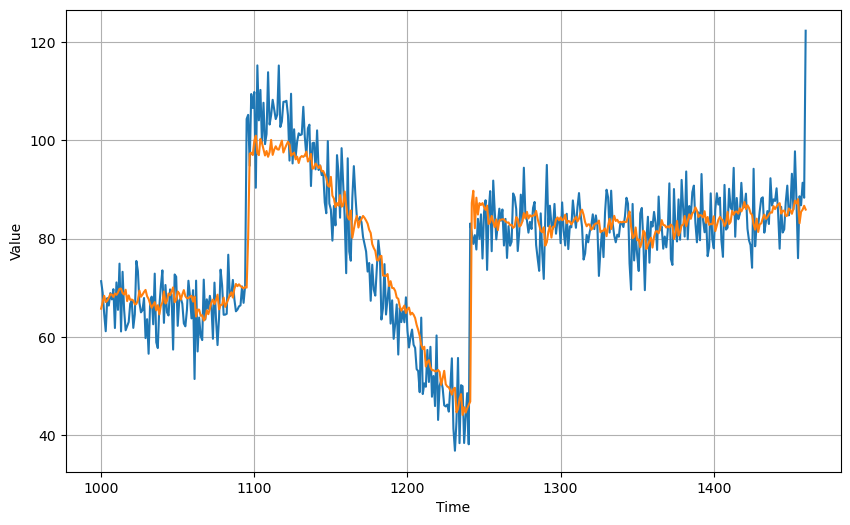

In [12]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

WAVENET

In [8]:

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(keras.layers.Conv1D(filters=32, kernel_size=2, strides=1, dilation_rate=dilation_rate, padding='causal', activation='relu'))
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30)
)



optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer='adam',
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=100,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, lr_schedule])

Epoch 1/100
      1/Unknown - 1s 1s/step - loss: 43.1464 - mae: 43.6447

2024-01-07 19:02:45.468886: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 9866669550244771932
2024-01-07 19:02:45.468912: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16904108061475540959
2024-01-07 19:02:45.468928: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8397546956283567792
2024-01-07 19:02:45.662899: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16904108061475540959
2024-01-07 19:02:45.662923: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8397546956283567792


8/8 [==============================] - 1s 34ms/step - loss: 43.0538 - mae: 43.5526 - val_loss: 79.0228 - val_mae: 79.5228 - lr: 1.0000e-04
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 42.7723 - mae: 43.2711 - val_loss: 78.5419 - val_mae: 79.0418 - lr: 1.0798e-04
Epoch 3/100
1/8 [==>...........................] - ETA: 0s - loss: 42.8762 - mae: 43.3752

/home/kb/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 0s 9ms/step - loss: 42.5484 - mae: 43.0473 - val_loss: 78.2237 - val_mae: 78.7237 - lr: 1.1659e-04
Epoch 4/100
8/8 [==============================] - 0s 18ms/step - loss: 42.3908 - mae: 42.8898 - val_loss: 77.9697 - val_mae: 78.4697 - lr: 1.2589e-04
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 42.2470 - mae: 42.7460 - val_loss: 77.6987 - val_mae: 78.1987 - lr: 1.3594e-04
Epoch 6/100
8/8 [==============================] - 0s 11ms/step - loss: 42.0784 - mae: 42.5775 - val_loss: 77.3228 - val_mae: 77.8228 - lr: 1.4678e-04
Epoch 7/100
8/8 [==============================] - 0s 11ms/step - loss: 41.8198 - mae: 42.3189 - val_loss: 76.6844 - val_mae: 77.1844 - lr: 1.5849e-04
Epoch 8/100
8/8 [==============================] - 0s 10ms/step - loss: 41.4044 - mae: 41.9036 - val_loss: 75.7048 - val_mae: 76.2048 - lr: 1.7113e-04
Epoch 9/100
8/8 [==============================] - 0s 11ms/step - loss: 40.6855 - mae: 41.1847 - val_loss: 

(0.0001, 0.1, 0.0, 30.0)

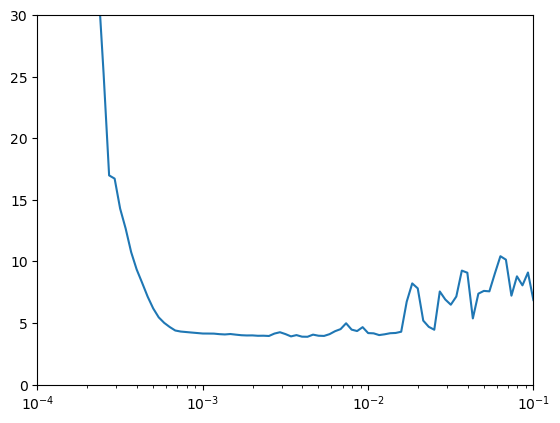

In [9]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-4, 1e-1, 0, 30])

In [10]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(keras.layers.Conv1D(filters=32, kernel_size=2, strides=1, dilation_rate=dilation_rate, padding='causal', activation='relu'))
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

optimizer = keras.optimizers.SGD(lr=1e-3, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer='adam',
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint_CNN.keras", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=100,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
8/8 [==============================] - 1s 36ms/step - loss: 41.0198 - mae: 41.5191 - val_loss: 71.6640 - val_mae: 72.1640
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 36.2501 - mae: 36.7489 - val_loss: 56.9447 - val_mae: 57.4447
Epoch 3/100
1/8 [==>...........................] - ETA: 0s - loss: 31.0354 - mae: 31.5333

/home/kb/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 0s 9ms/step - loss: 23.7747 - mae: 24.2709 - val_loss: 23.4573 - val_mae: 23.9526
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 15.1829 - mae: 15.6762 - val_loss: 21.8599 - val_mae: 22.3555
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 11.2631 - mae: 11.7516 - val_loss: 16.6683 - val_mae: 17.1614
Epoch 6/100
8/8 [==============================] - 0s 16ms/step - loss: 8.6170 - mae: 9.1020 - val_loss: 10.5711 - val_mae: 11.0580
Epoch 7/100
8/8 [==============================] - 0s 10ms/step - loss: 7.0881 - mae: 7.5714 - val_loss: 9.1081 - val_mae: 9.5953
Epoch 8/100
8/8 [==============================] - 0s 9ms/step - loss: 6.0746 - mae: 6.5557 - val_loss: 7.3106 - val_mae: 7.7941
Epoch 9/100
8/8 [==============================] - 0s 14ms/step - loss: 5.2231 - mae: 5.7019 - val_loss: 5.8837 - val_mae: 6.3644
Epoch 10/100
8/8 [==============================] - 0s 9ms/step - loss: 4.8775 - mae: 5.35

In [11]:
model = keras.models.load_model("my_checkpoint.keras")
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

45/45 [==============================] - 0s 4ms/step


2024-01-07 19:06:51.544408: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8397546956283567792


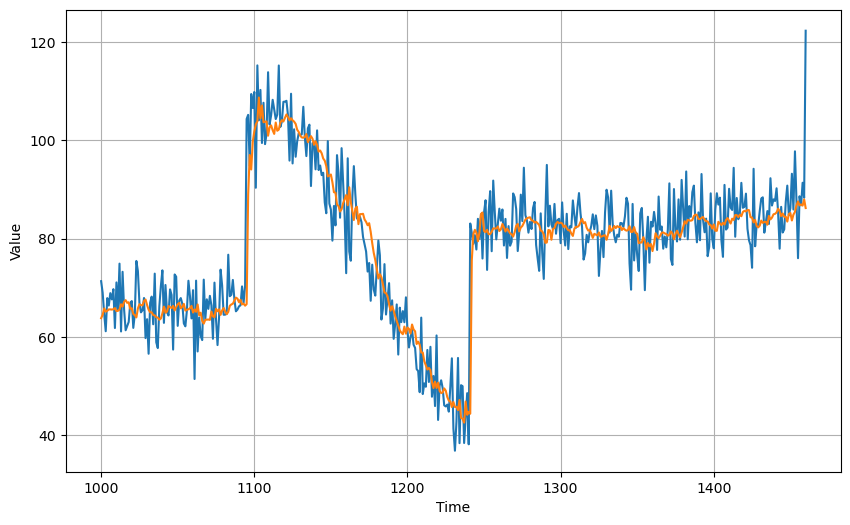

In [15]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

In [16]:
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

4.623608